# Performance evaluation of the pre-trained RoBERTa classifier used in the Coan et al. (2021) article 'Computer-assisted detection and classification of misinformation about climate change'

## Setup

In [ ]:
# Load the required packages

# Dataframes
import pandas as pd

# Regular expressions
import re

# Unidecoder
import unicodedata

# Timestamp / time measurment
import time

# Simpletransformers classifier
from simpletransformers.classification import ClassificationModel

# Label encode
from sklearn.preprocessing import LabelEncoder

# Class weights
from sklearn.utils.class_weight import compute_class_weight

# Model performance scores
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# PyTorch: enable GPU access
import torch

# If you want to select a specific GPU, set it here:
# gpu = 0
# torch.cuda.set_device(gpu)

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use GPU {}:'.format(torch.cuda.current_device()), torch.cuda.get_device_name(torch.cuda.current_device()))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image 

There are 1 GPU(s) available.
We will use GPU 0: NVIDIA GeForce GTX 1080 Ti


In [ ]:
# Define required functions

# Define additional model performance scores (F1)
def f1_multiclass_macro(labels, preds):
    return f1_score(labels, preds, average='macro')
def f1_multiclass_micro(labels, preds):
    return f1_score(labels, preds, average='micro')
def f1_multiclass_weighted(labels, preds):
    return f1_score(labels, preds, average='weighted')
def f1_class(labels, preds):
    return f1_score(labels, preds, average=None)
def precision(labels, preds):
    return precision_score(labels, preds, average='macro')
def recall(labels, preds):
    return recall_score(labels, preds, average='macro')

# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()

## Data Preparation

In [ ]:
# Load and pre-process the text data

# Load the data
valid = pd.read_csv('training/valid.csv').rename(columns={"claim": "labels_orig"})
test = pd.read_csv('training/test.csv').rename(columns={"claim": "labels_orig"})

# Pre-process the text
valid['text'] = valid['text'].astype(str).apply(denoise_text)
test['text'] = test['text'].astype(str).apply(denoise_text)

# Load the label encoder
label_encoder = LabelEncoder()

# Encode the labels
valid['labels'] = label_encoder.fit_transform(valid.labels_orig)
test['labels'] = label_encoder.fit_transform(test.labels_orig)

In [ ]:
test['labels'].unique

<bound method Series.unique of 0       16
1        0
2        0
3        7
4        7
        ..
2899    17
2900    17
2901    17
2902    17
2903    17
Name: labels, Length: 2904, dtype: int64>

## Evaluate the performance of the pre-trained RoBERTa classifier used in the Coan et al. (2021) article


In [ ]:
%%time

# Define model
architecture = 'roberta'

# Define trained classifier
model_name = '/home/users/mhossain/project/models/CARDS_RoBERTa_Classifier'

# Load the classifier
model = ClassificationModel(architecture, model_name)

# Evaluate the model on the validation data
result, model_outputs, wrong_predictions = model.eval_model(valid,
                                                            f1_macro = f1_multiclass_macro,
                                                            precision = precision,
                                                            recall = recall,
                                                            acc = accuracy_score,
                                                            f1_micro = f1_multiclass_micro,
                                                            f1_weighted = f1_multiclass_weighted,
                                                            f1_class = f1_class)

# Evaluate the model on the testing data
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(test,
                                                                           f1_macro = f1_multiclass_macro,
                                                                           precision = precision,
                                                                           recall = recall,
                                                                           acc = accuracy_score,
                                                                           f1_micro = f1_multiclass_micro,
                                                                           f1_weighted = f1_multiclass_weighted,
                                                                           f1_class = f1_class)

# Print results
print('\n\nThese are the results when testing the model on the validation data set:\n')
print(result)

print('\n\nThese are the results when testing the model on the testing data set:\n')
print(result_test)

Some weights of the model checkpoint at /home/users/mhossain/project/models/CARDS_RoBERTa_Classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2605 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/2904 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1072 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


Running Evaluation:   0%|          | 0/378 [00:00<?, ?it/s]



These are the results when testing the model on the validation data set:

{'mcc': 0.7362666033643798, 'f1_macro': 0.7560843335551517, 'precision': 0.7495417199503335, 'recall': 0.7686662236308703, 'acc': 0.8606525911708254, 'f1_micro': 0.8606525911708254, 'f1_weighted': 0.8641104105396743, 'f1_class': array([0.92112676, 0.83076923, 0.76470588, 0.85714286, 0.81818182,
       0.92682927, 0.83168317, 0.77005348, 0.725     , 0.75555556,
       0.90909091, 0.94444444, 0.46511628, 0.58536585, 0.49056604,
       0.7       , 0.72      , 0.59388646]), 'eval_loss': 0.7350488194475876}


These are the results when testing the model on the testing data set:

{'mcc': 0.7750057433603067, 'f1_macro': 0.7716612861371486, 'precision': 0.8127220243195646, 'recall': 0.7448812139071929, 'acc': 0.8639807162534435, 'f1_micro': 0.8639807162534435, 'f1_weighted': 0.8598098130846593, 'f1_class': array([0.92384658, 0.73333333, 0.72727273, 0.81481481, 0.736     ,
       0.92307692, 0.88709677, 0.84      , 0.72

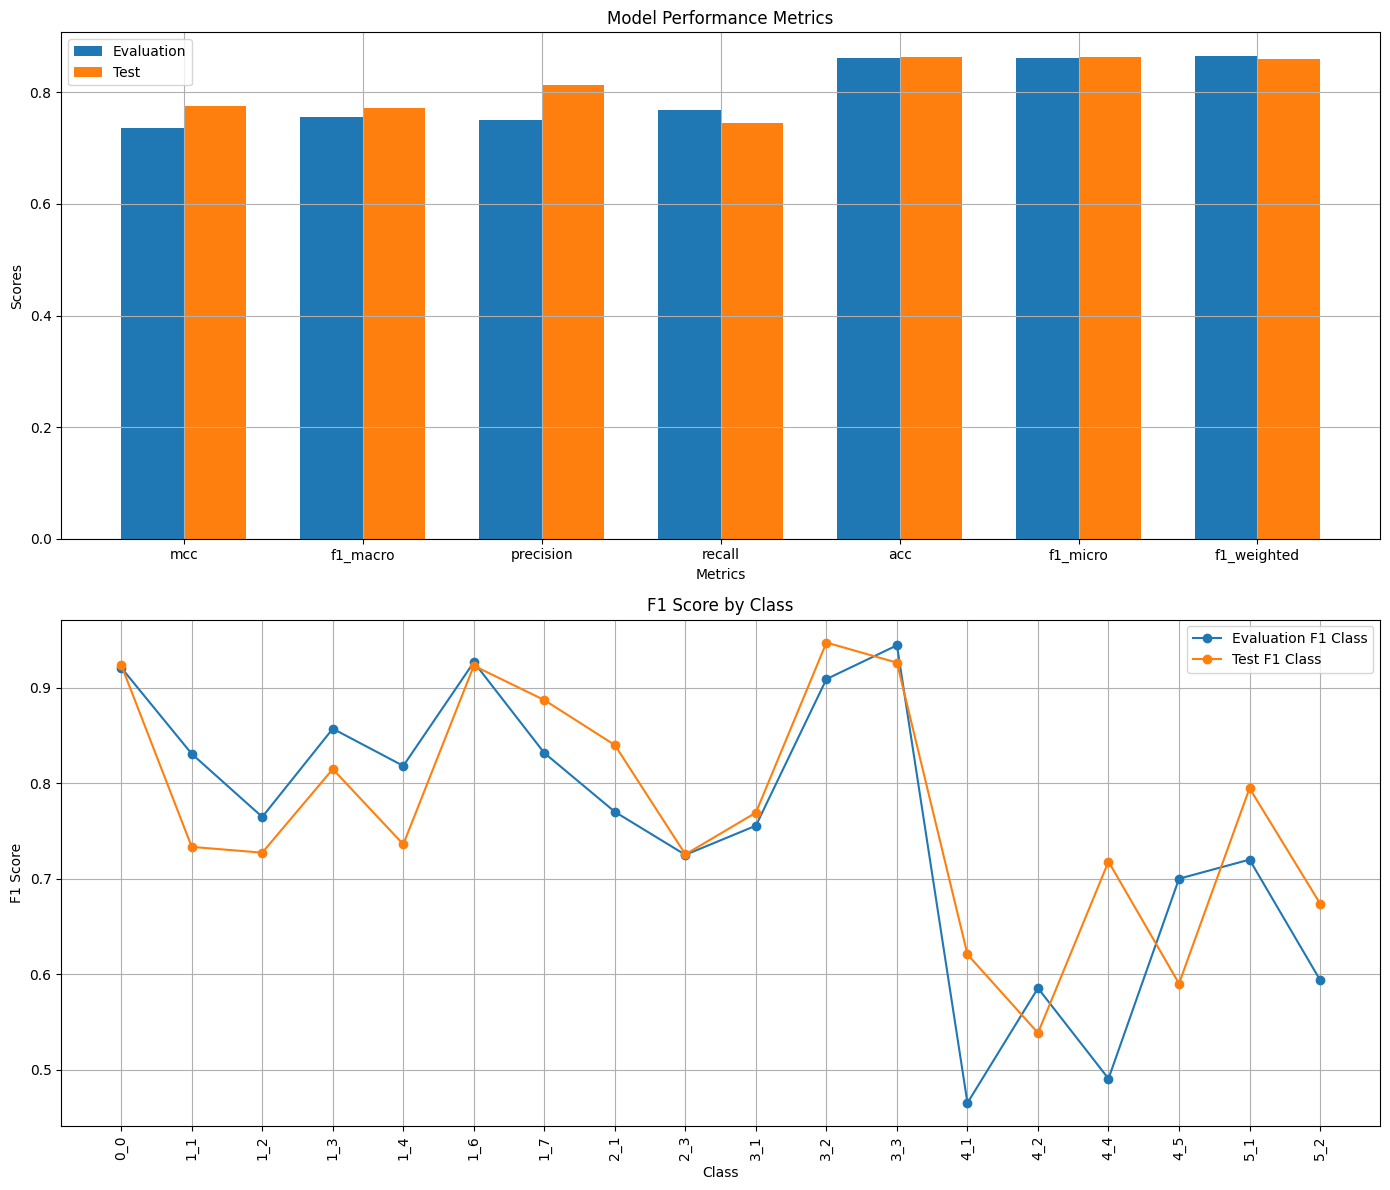

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the results
train_results = {
    'mcc': 0.7362666033643798,
    'f1_macro': 0.7560843335551517,
    'precision': 0.7495417199503335,
    'recall': 0.7686662236308703,
    'acc': 0.8606525911708254,
    'f1_micro': 0.8606525911708254,
    'f1_weighted': 0.8641104105396743,
    'f1_class': np.array([0.92112676, 0.83076923, 0.76470588, 0.85714286, 0.81818182,
                          0.92682927, 0.83168317, 0.77005348, 0.725, 0.75555556,
                          0.90909091, 0.94444444, 0.46511628, 0.58536585, 0.49056604,
                          0.7, 0.72, 0.59388646]),
    'eval_loss': 0.7350488194475876
}

test_results = {
    'mcc': 0.7750057433603067,
    'f1_macro': 0.7716612861371486,
    'precision': 0.8127220243195646,
    'recall': 0.7448812139071929,
    'acc': 0.8639807162534435,
    'f1_micro': 0.8639807162534435,
    'f1_weighted': 0.8598098130846593,
    'f1_class': np.array([0.92384658, 0.73333333, 0.72727273, 0.81481481, 0.736,
                          0.92307692, 0.88709677, 0.84, 0.7254902, 0.76923077,
                          0.94736842, 0.92631579, 0.62068966, 0.53846154, 0.71794872,
                          0.59016393, 0.79475983, 0.67403315]),
    'eval_loss': 0.7707455522090039
}

# Metrics for bar plot
metrics = ['mcc', 'f1_macro', 'precision', 'recall', 'acc', 'f1_micro', 'f1_weighted']
train_values = [train_results[metric] for metric in metrics]
test_values = [test_results[metric] for metric in metrics]

# F1 scores by class for line plot
train_f1_class = train_results['f1_class']
test_f1_class = test_results['f1_class']
classes = np.arange(1, len(train_f1_class) + 1)



# Create figure and axes with grid enabled
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Bar plot for metrics
x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, eval_values, width, label='Evaluation')
ax1.bar(x + width/2, test_values, width, label='Test')

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Scores')
ax1.set_title('Model Performance Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True)  # Enable grid

# Line plot for F1 scores by class
ax2.plot(classes, eval_f1_class, marker='o', label='Evaluation F1 Class')
ax2.plot(classes, test_f1_class, marker='o', label='Test F1 Class')

ax2.set_xlabel('Class')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score by Class')
ax2.set_xticks(classes)
ax2.set_xticklabels(class_names, rotation=90)
ax2.legend()
ax2.grid(True)  # Enable grid

# Adjust layout
plt.tight_layout()

plt.savefig('Model Performance Metrics.png')

# Show plot
plt.show()
